In [1]:
# #TO DO 
# OUTPUT GIBBS MCMC MOVES
# INCORPORATE TQDM
# CHECK THE LOWEST POSSIBLE NSTEPS WITHOUT FAILING
# PLOT ORIENTATION PARAMETERS

In [2]:
# load some necessary modules
from dmipy.core import modeling_framework
from os.path import join
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

/Users/paddyslator/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# load HCP acqusition scheme 
from dmipy.data import saved_acquisition_schemes

acq_scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

In [4]:
#set up a simple GM/WM/CSF image


#bigger image
dimx=25
dimy=25
#0 is WM, 1 is GM, 2 is CSF
simROIs = np.zeros((dimx,dimy))

simROIs[0:10,:] = 0
simROIs[10:20,:] = 1
simROIs[20:25,:] = 2


simmask = np.ones((dimx,dimy))



In [5]:
#set up NODDI model 
from dmipy.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()

from dmipy.distributions.distribute_models import SD1WatsonDistributed
watson_dispersed_bundle = SD1WatsonDistributed(models=[stick, zeppelin])

watson_dispersed_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
watson_dispersed_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
#fix the diffusivities
watson_dispersed_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)

from dmipy.core.modeling_framework import MultiCompartmentModel
NODDI_mod = MultiCompartmentModel(models=[ball, watson_dispersed_bundle])

NODDI_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

We highly recommend installing pathos to take advantage of multicore processing.


In [6]:
NODDI_mod.parameter_ranges

OrderedDict([('SD1WatsonDistributed_1_partial_volume_0', (0.01, 0.99)),
             ('SD1WatsonDistributed_1_SD1Watson_1_odi', (0.02, 0.99)),
             ('SD1WatsonDistributed_1_SD1Watson_1_mu',
              ([0, 3.141592653589793],
               [-3.141592653589793, 3.141592653589793])),
             ('partial_volume_0', (0.01, 0.99)),
             ('partial_volume_1', (0.01, 0.99))])

In [7]:
#choose some parameters for the simulated NODDI model 
mu = (np.pi, 0) 
SD1WatsonDistributed_1_SD1Watson_1_odi = [0.2, 0.6, 0.7]
SD1WatsonDistributed_1_partial_volume_0 = [0.8, 0.6, 0.9]
partial_volume_0 = [0.1, 0.1, 0.9]
partial_volume_1 = [1-x for x in partial_volume_0]


#lambda_par = 1.7e-9  # in m^2/s
#lambda_iso = 3e-9  # in m^2/s
#f_0 = 0.3
#f_1 = 0.7

parameter_vector = NODDI_mod.parameters_to_parameter_vector(
    SD1WatsonDistributed_1_SD1Watson_1_mu = mu,
    SD1WatsonDistributed_1_SD1Watson_1_odi = SD1WatsonDistributed_1_SD1Watson_1_odi, 
    SD1WatsonDistributed_1_partial_volume_0 = SD1WatsonDistributed_1_partial_volume_0,
    partial_volume_0 = partial_volume_0,
    partial_volume_1 = partial_volume_1)

#simulate a single voxel for each ROI
nmeas = len(acq_scheme.bvalues)
E = NODDI_mod.simulate_signal(acq_scheme, parameter_vector)
    

# add some noise
#E_real = E + np.random.normal(scale=0.01, size=(3, acq_scheme.number_of_measurements))
#E_imag = np.random.normal(scale=0.01, size=(3, acq_scheme.number_of_measurements))
#E = np.sqrt(E_real**2 + E_imag**2)

    
    

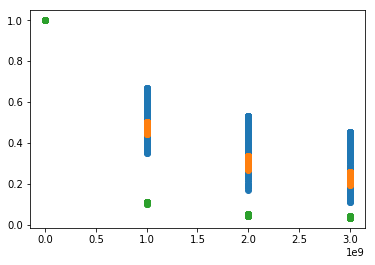

In [8]:
for i in range(0,3):
    plt.plot(acq_scheme.bvalues,E[i,:],'o')

In [9]:
parameter_vector

array([[0.8       , 0.2       , 3.14159265, 0.        , 0.1       ,
        0.9       ],
       [0.6       , 0.6       , 3.14159265, 0.        , 0.1       ,
        0.9       ],
       [0.9       , 0.7       , 3.14159265, 0.        , 0.9       ,
        0.1       ]])

In [10]:
NODDI_mod.parameter_names

['SD1WatsonDistributed_1_partial_volume_0',
 'SD1WatsonDistributed_1_SD1Watson_1_odi',
 'SD1WatsonDistributed_1_SD1Watson_1_mu',
 'partial_volume_0',
 'partial_volume_1']

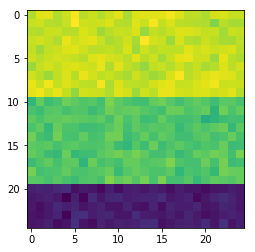

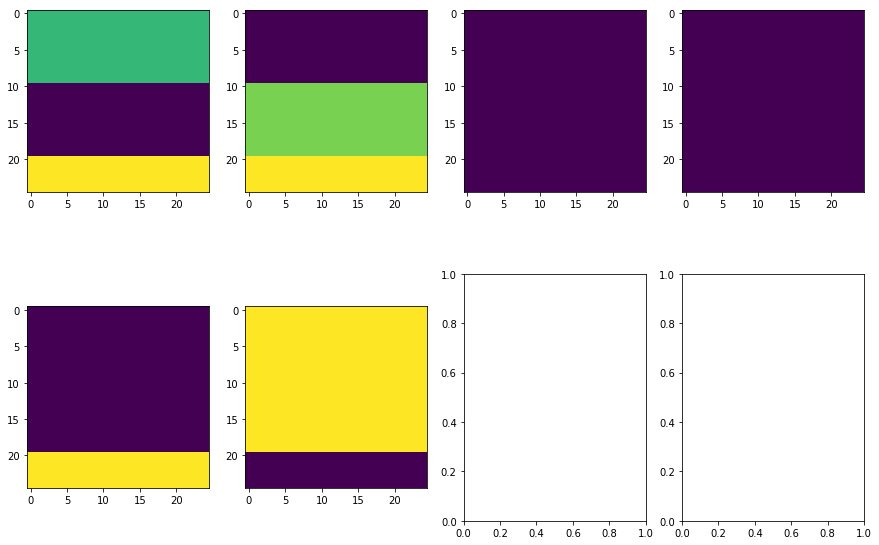

In [11]:
#simulate the image
simimg = np.zeros((dimx,dimy,np.shape(E)[1]))

nparam=6
param_map = np.zeros((dimx,dimy,nparam))


for x in range(0,dimx):
    for y in range(0,dimy):
        simimg[x,y,:] = E[int(simROIs[x,y]),:] + np.random.normal(0,0.02,nmeas) 
                
        param_map[x,y,:]=parameter_vector[int(simROIs[x,y]),:]

    

plt.imshow(simimg[:,:,10])


fig, axs = plt.subplots(2, 4, figsize=[15, 10])
axs = axs.ravel()

for i in range(0,nparam):
    axs[i].imshow(param_map[:,:,i])

    
    


# #more interesting image

# dimx=10
# dimy=10
# simimg = np.zeros((dimx,dimy,len(E)))
# nparam=5
# param_map = np.zeros((dimx,dimy,6))

# for x in range(0,dimx):
#     for y in range(0,dimy):
#         #random parameters
#         mu = np.random.uniform(low=[0,-np.pi],high=[np.pi,np.pi]) 
#         lambda_par = np.random.uniform(low=1e-9,high=2e-9) # in m^2/s
#         lambda_iso = np.random.uniform(low=1.5e-9,high=3e-9)  # in m^2/s
#         f_0 = np.random.uniform(low=0,high=1)
#         f_1 = 1-f_0

#         parameter_vector = ballstick.parameters_to_parameter_vector(
#             C1Stick_1_mu = mu,
#             C1Stick_1_lambda_par=lambda_par, 
#             G1Ball_1_lambda_iso=lambda_iso,
#             partial_volume_0 = f_0,
#             partial_volume_1 = f_1)

#         #simulate this voxel
#         nmeas = len(acq_scheme.bvalues)
#         E = ballstick.simulate_signal(acq_scheme, parameter_vector)

#         simimg[x,y,:] = E + np.random.normal(0,0.01,nmeas) 
        
        
        


In [12]:
import asyncio
from importlib import reload

import fit_bayes
from fit_bayes import fit, tform_params  # , dict_to_array, array_to_dict
fit_bayes = reload(fit_bayes)

nsteps=1000
burn_in=500

#rearrange the data
data = np.reshape(simimg, (dimx*dimy, nmeas))
mask = np.reshape(simmask, dimx*dimy)
simROIs = np.reshape(simROIs,dimx*dimy)
simROIsmask = simROIs + 1



#priors defined over the whole image
#acceptance_rate, param_conv, params_all_new, params_all_orig, likelihood_stored, w_stored = fit_bayes.fit(NODDI_mod, acq_scheme, data, mask, nsteps, burn_in)
#priors defined over the ROIs
acceptance_rate_ROIs, param_conv_ROIs, params_all_new_ROIs, params_all_orig_ROIs, likelihood_stored_ROIs, w_stored_ROIs = fit_bayes.fit(NODDI_mod, acq_scheme, data, simROIsmask, nsteps, burn_in)

#reshape them



Setup brute2fine optimizer in 1.5954430103302002 seconds
Fitting of 625 voxels complete in 26.055023908615112 seconds.
Average of 0.04168803825378418 seconds per voxel.
ROI 1/3; 250 voxels


/Users/paddyslator/dmipy-bayesian/fit_bayes.py:237: RuntimeWarning: divide by zero encountered in log
  prior_new = prior_new + np.log(scipy.stats.multivariate_normal.pdf(parameter_vector, mu, sigma, allow_singular=1))


ROI 2/3; 250 voxels
ROI 3/3; 125 voxels


/Users/paddyslator/dmipy-bayesian/fit_bayes.py:292: RuntimeWarning: divide by zero encountered in true_divide
  w[param][idx_roi] = w[param][idx_roi] * 101 / (2 * (101 - (accepted_per_100[param][idx_roi])))
/Users/paddyslator/dmipy-bayesian/fit_bayes.py:26: RuntimeWarning: invalid value encountered in true_divide
  param_dict[param] = (lb + ub * np.exp(param_dict[param])) / (1 + np.exp(param_dict[param]))
/Users/paddyslator/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/paddyslator/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [13]:
params_img_bayes = {}

params_img_lsq = {}


for i in params_all_new_ROIs.keys():
    print(i)
    if NODDI_mod.parameter_cardinality[i] == 1:
        params_img_bayes[i] = np.reshape(params_all_new_ROIs[i],(dimx,dimy))
        
        params_img_lsq[i] = np.reshape(params_all_orig_ROIs[i],(dimx,dimy))
        
    #else:
        #params_img_bayes[i] = np.reshape(params_all_new[i],(dimx,dimy,2))
        
        #params_img_lsq[i] = np.reshape(params_all_orig[i],(dimx,dimy,2))
        
    
    #params_img[i] = np.flip(params_img[i].transpose(1,0),0)
    
    
#make a ground truth parameter map dictionary in the same formt
params_img_gt = {}
l=0
for i in NODDI_mod.parameter_names:
    print(i)
    if NODDI_mod.parameter_cardinality[i] == 1:
        params_img_gt[i] = param_map[:,:,l]
        l=l+1
    else:
    #    params_img_gt[i] = param_map[:,:,l:l+1]
        l=l+2

SD1WatsonDistributed_1_partial_volume_0
partial_volume_0
SD1WatsonDistributed_1_SD1Watson_1_odi
SD1WatsonDistributed_1_SD1Watson_1_mu
partial_volume_1
SD1WatsonDistributed_1_partial_volume_0
SD1WatsonDistributed_1_SD1Watson_1_odi
SD1WatsonDistributed_1_SD1Watson_1_mu
partial_volume_0
partial_volume_1


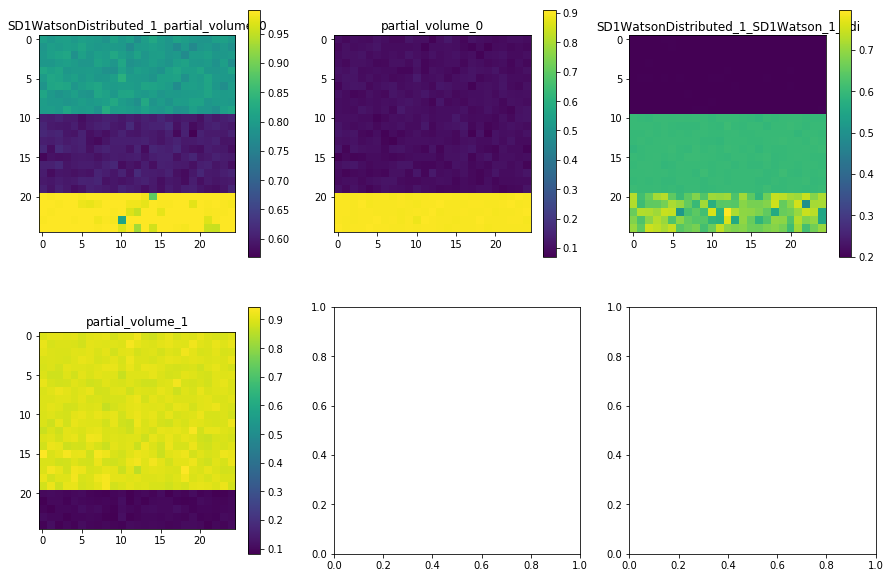

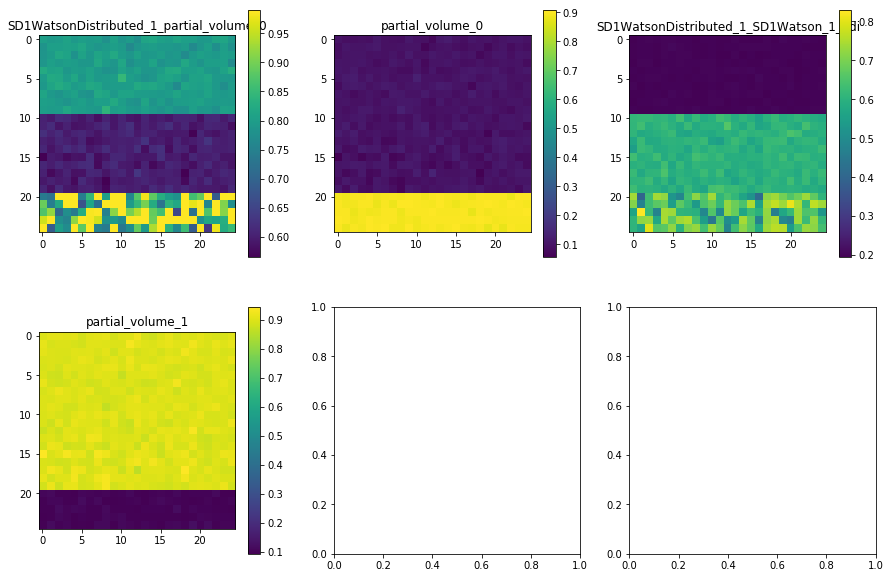

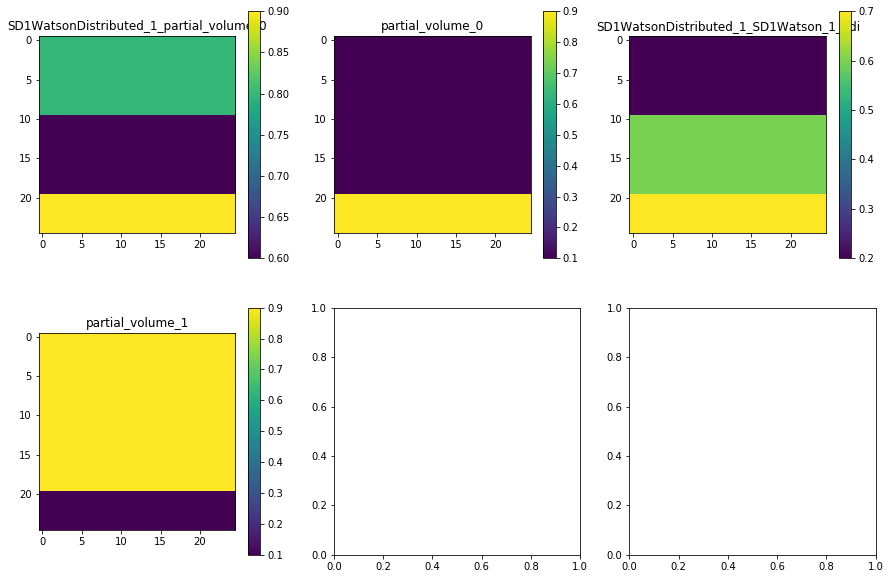

In [14]:
#plot the Bayesian maps without fixed diffusivity
fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

l=0
for j in params_all_new_ROIs.keys():
    if NODDI_mod.parameter_cardinality[j] == 1:
        bayes_map = axs[l].imshow(params_img_bayes[j])
        axs[l].set_title(j)
        fig.colorbar(bayes_map, ax=axs[l])
        l=l+1
    #else:
    #    axs[l].imshow(params_img[j])
    #    axs[l+1].imshow(params_img[j])
    #    l=l+2
    
    
#plot the LSQ maps without fixed diffusivity
fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

l=0
for j in params_all_orig_ROIs.keys():
    if NODDI_mod.parameter_cardinality[j] == 1:
        lsq_map = axs[l].imshow(params_img_lsq[j])
        axs[l].set_title(j)
        fig.colorbar(lsq_map, ax=axs[l])
        l=l+1
    #else:
    #    axs[l].imshow(params_img[j])
    #    axs[l+1].imshow(params_img[j])
    #    l=l+2
    

#plot the GT maps without fixed diffusivity
fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

l=0
for j in params_all_orig_ROIs.keys():
    if NODDI_mod.parameter_cardinality[j] == 1:
        gt_map = axs[l].imshow(params_img_gt[j])
        axs[l].set_title(j)
        fig.colorbar(gt_map, ax=axs[l])
        l=l+1
        
        


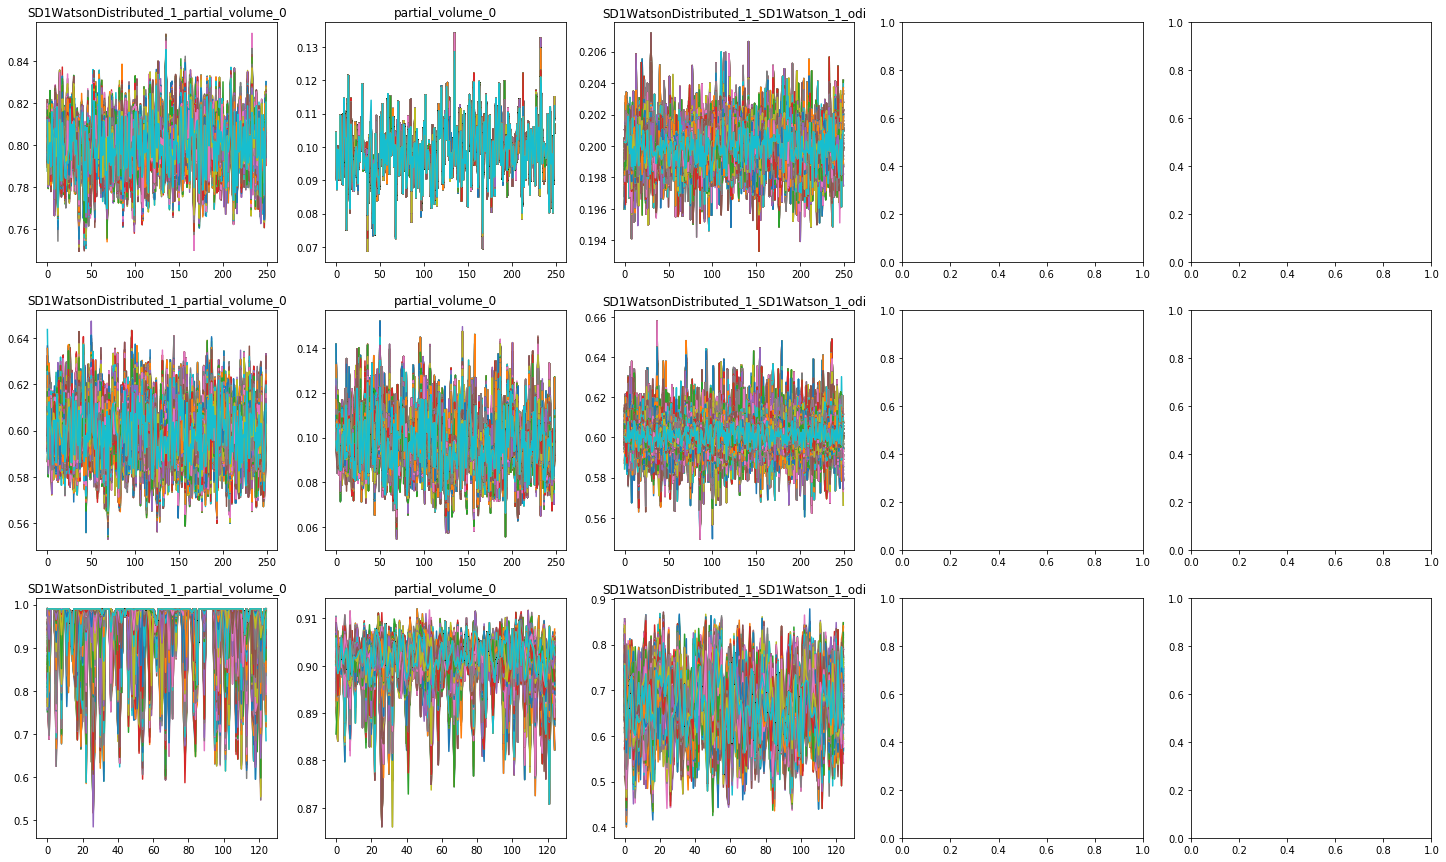

In [15]:
fig,axs = plt.subplots(3 , 5, figsize=[25, 15])

for i in range(0,3):
    k=0
    l=0
    for j in param_conv_ROIs.keys():
        if NODDI_mod.parameter_cardinality[j] == 1:
            axs[i,k].plot(param_conv_ROIs[j][simROIs==i,:])
            #add the ground truth
            #axs[i,k].plot(0,parameter_vector[i,l],'kx')
            axs[i,k].set_title(j)
            k=k+1
            l=l+1
        else:
            l=l+2
    

Text(0.5,1,'Bayesian')

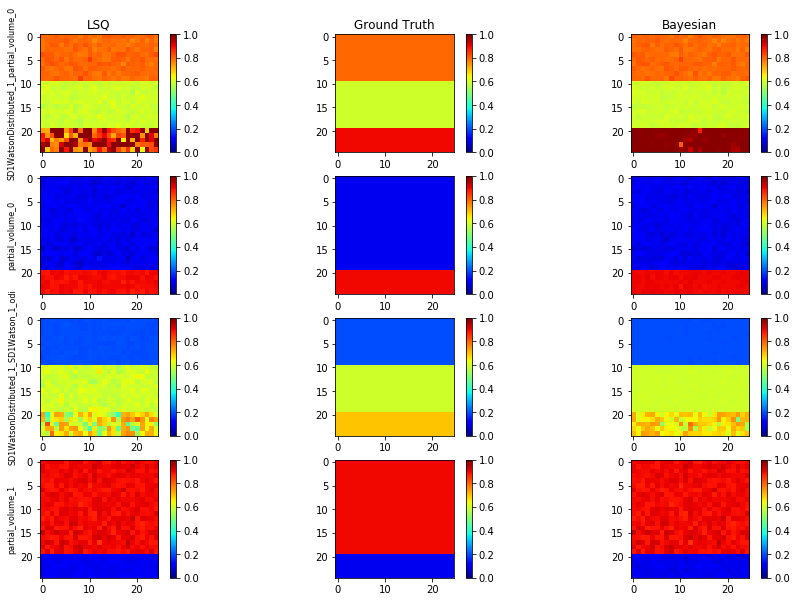

In [16]:
fig, axs = plt.subplots(4 , 3, figsize=[15, 10])

l=0
for j in params_all_new_ROIs.keys():
    if NODDI_mod.parameter_cardinality[j] == 1:
        #plot the lsq in the 1st row
        colormap_lsq = axs[l,0].imshow(params_img_lsq[j], vmin=0, vmax=1,cmap='jet')            
        axs[l,0].set_ylabel(j,fontsize=8)
        fig.colorbar(colormap_lsq, ax=axs[l,0])
        
        #plot the ground truth in the 2nd row
        colormap_gt = axs[l,1].imshow(params_img_gt[j], vmin=0, vmax=1,cmap='jet')     
        fig.colorbar(colormap_gt, ax=axs[l,1])
            
        #plot the bayesian in the 3rd row
        colormap_bayes = axs[l,2].imshow(params_img_bayes[j], vmin=0, vmax=1,cmap='jet')     
        fig.colorbar(colormap_bayes, ax=axs[l,2])
       
        l=l+1
    #else:
     #   =i+2
    #else:
    #    axs[l].imshow(params_img[j])
    #    axs[l+1].imshow(params_img[j])
    #    l=l+2
    

    
axs[0,0].set_title('LSQ')
axs[0,1].set_title('Ground Truth')
axs[0,2].set_title('Bayesian')


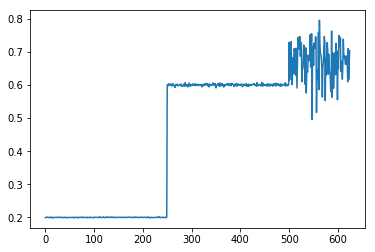

In [17]:
plt.plot(params_all_new_ROIs['SD1WatsonDistributed_1_SD1Watson_1_odi'])

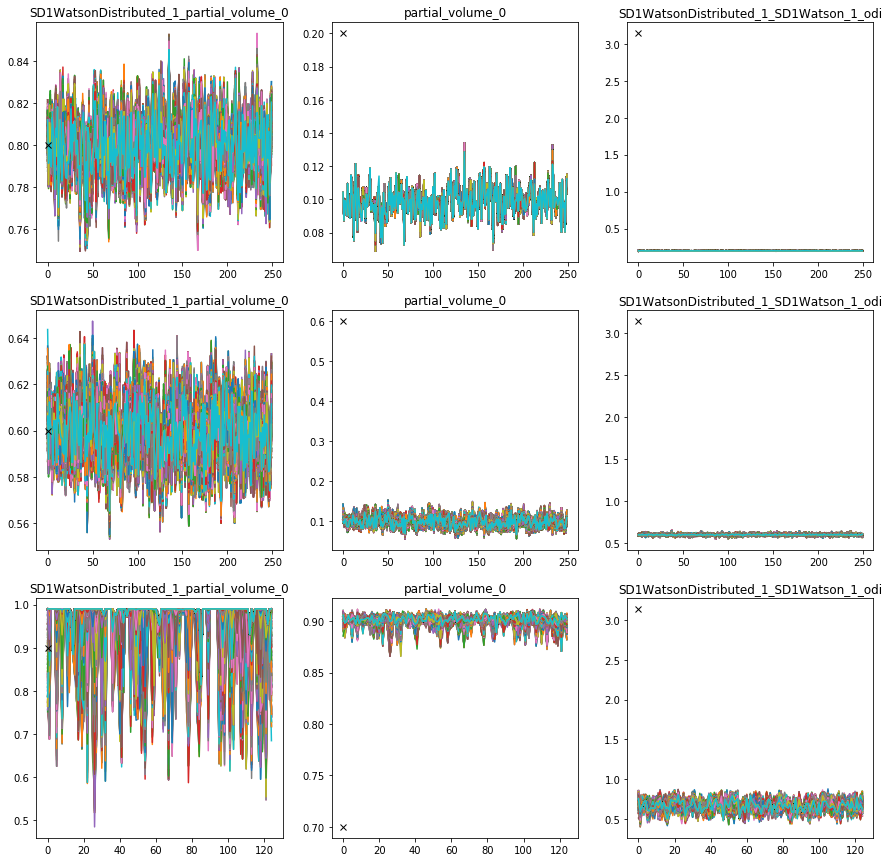

In [18]:
fig,axs = plt.subplots(3 , 3, figsize=[15, 15])

for i in range(0,3):
    k=0
    l=0
    for j in param_conv_ROIs.keys():
        if NODDI_mod.parameter_cardinality[j] == 1:
            axs[i,k].plot(param_conv_ROIs[j][simROIs==i,:])
            #add the ground truth
            axs[i,k].plot(0,parameter_vector[i,l],'kx')
            axs[i,k].set_title(j)
            k=k+1
            l=l+1
        else:
            l=l+2
    
            
    
    

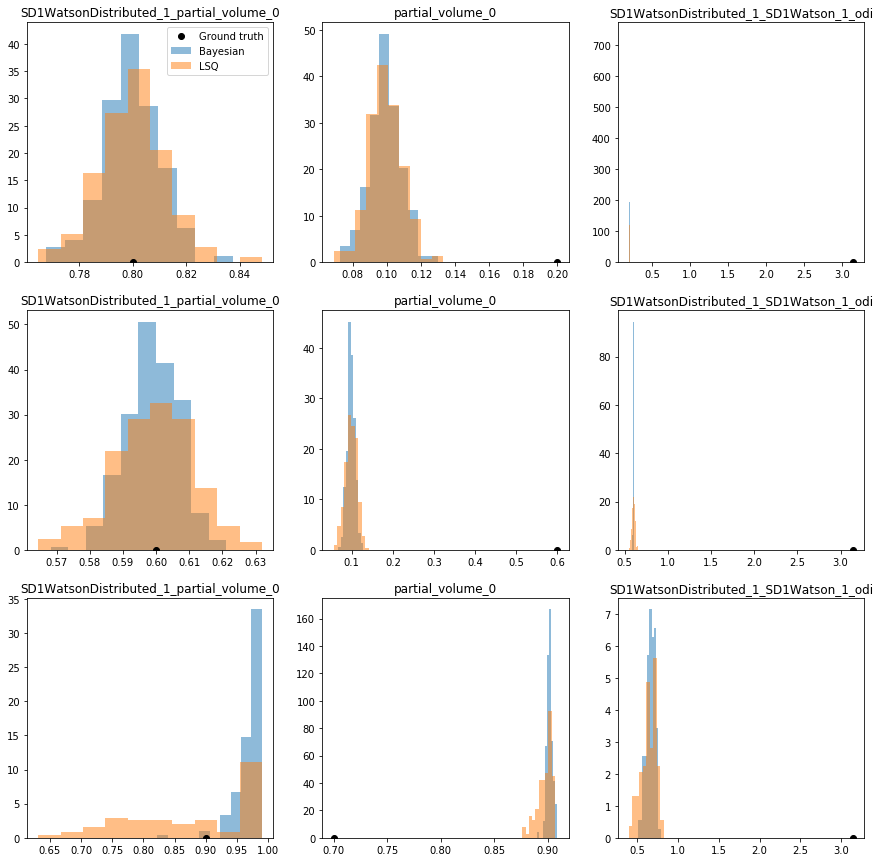

In [19]:
#plot histograms of LSQ and Bayesian for all voxels in each ROI
fig,axs = plt.subplots(3 , 3, figsize=[15, 15])

for i in range(0,3):
    k=0
    l=0
    for j in param_conv_ROIs.keys():
        if NODDI_mod.parameter_cardinality[j] == 1:
            #histogram of MCMC means for each voxel        
            axs[i,k].hist(np.mean(param_conv_ROIs[j],1)[simROIs==i], alpha=0.5, density=True)
            #histogram of LSQ values
            axs[i,k].hist(params_all_orig_ROIs[j][simROIs==i], alpha=0.5, density=True)
            #add the ground truth
            axs[i,k].plot(parameter_vector[i,l],0,'ko')
            axs[i,k].set_title(j)
            k=k+1
            l=l+1
        else:
            l=l+2
            
axs[0,0].legend(('Ground truth','Bayesian','LSQ'))
    

In [20]:
#now try fitting NODDI without fixing the diffusion parameters

#set up NODDI model 
from dmipy.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()

from dmipy.distributions.distribute_models import SD1WatsonDistributed
watson_dispersed_bundle = SD1WatsonDistributed(models=[stick, zeppelin])

watson_dispersed_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
watson_dispersed_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
#see what happens when you don't fix the diffusivities!
#watson_dispersed_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)

from dmipy.core.modeling_framework import MultiCompartmentModel
NODDI_mod = MultiCompartmentModel(models=[ball, watson_dispersed_bundle])

#NODDI_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)


We highly recommend installing pathos to take advantage of multicore processing.


In [21]:
#choose some parameters for the simulated NODDI model  with diffusivities
mu = (np.pi, 0) 
SD1WatsonDistributed_1_SD1Watson_1_odi = [0.2, 0.6, 0.7]
SD1WatsonDistributed_1_partial_volume_0 = [0.8, 0.6, 0.9]
partial_volume_0 = [0.1, 0.1, 0.9]
partial_volume_1 = [1-x for x in partial_volume_0]


lambda_par = 1.7e-9  # in m^2/s
lambda_iso = 3e-9  # in m^2/s
#f_0 = 0.3
#f_1 = 0.7

parameter_vector = NODDI_mod.parameters_to_parameter_vector(
    SD1WatsonDistributed_1_SD1Watson_1_mu = mu,
    SD1WatsonDistributed_1_SD1Watson_1_odi = SD1WatsonDistributed_1_SD1Watson_1_odi, 
    SD1WatsonDistributed_1_partial_volume_0 = SD1WatsonDistributed_1_partial_volume_0,
    partial_volume_0 = partial_volume_0,
    partial_volume_1 = partial_volume_1,
    SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par = lambda_par,
    G1Ball_1_lambda_iso = lambda_iso)

#simulate a single voxel for each ROI
nmeas = len(acq_scheme.bvalues)
E = NODDI_mod.simulate_signal(acq_scheme, parameter_vector)
    

# add some noise
#E_real = E + np.random.normal(scale=0.01, size=(3, acq_scheme.number_of_measurements))
#E_imag = np.random.normal(scale=0.01, size=(3, acq_scheme.number_of_measurements))
#E = np.sqrt(E_real**2 + E_imag**2)



    

In [22]:
#play around with parameter ranges
NODDI_mod.parameter_ranges['SD1WatsonDistributed_1_G2Zeppelin_1_lambda_par']=(1.65,1.75)
NODDI_mod.parameter_ranges['G1Ball_1_lambda_iso']=(2.95,3.05)

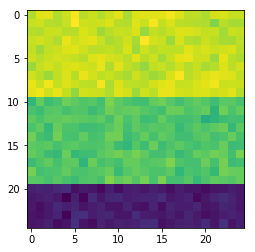

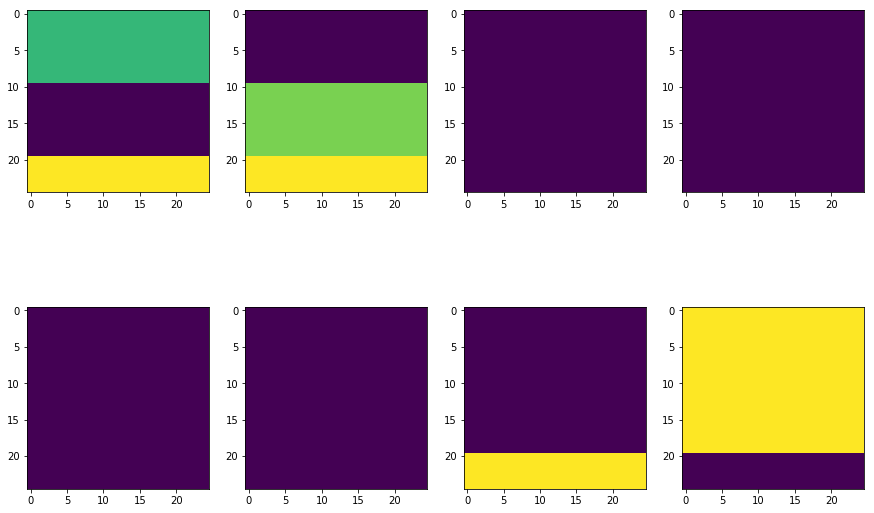

In [27]:
#set up a simple GM/WM/CSF image


#bigger image
dimx=25
dimy=25
#0 is WM, 1 is GM, 2 is CSF
simROIs = np.zeros((dimx,dimy))

simROIs[0:10,:] = 0
simROIs[10:20,:] = 1
simROIs[20:25,:] = 2


simmask = np.ones((dimx,dimy))



#simulate the image

simimg_nofix = np.zeros((dimx,dimy,np.shape(E)[1]))

nparam=8
param_map_nofix = np.zeros((dimx,dimy,nparam))


for x in range(0,dimx):
    for y in range(0,dimy):
        simimg_nofix[x,y,:] = E[int(simROIs[x,y]),:] + np.random.normal(0,0.04,nmeas) 
                
        param_map_nofix[x,y,:]=parameter_vector[int(simROIs[x,y]),:]

    

plt.imshow(simimg[:,:,10])


fig, axs = plt.subplots(2, 4, figsize=[15, 10])
axs = axs.ravel()

for i in range(0,nparam):
    axs[i].imshow(param_map_nofix[:,:,i])

In [ ]:
import asyncio
from importlib import reload

import fit_bayes
from fit_bayes import fit, tform_params  # , dict_to_array, array_to_dict
fit_bayes = reload(fit_bayes)

nsteps=1000
burn_in=500

#rearrange the data 
data = np.reshape(simimg, (dimx*dimy, nmeas))
mask = np.reshape(simmask, dimx*dimy)
simROIs = np.reshape(simROIs,dimx*dimy)
simROIsmask = simROIs + 1



#priors defined over the whole image
#acceptance_rate_nofix, param_conv_nofix, params_all_new_nofix, params_all_orig_nofix, likelihood_stored_nofix, w_stored_nofix = fit_bayes.fit(NODDI_mod, acq_scheme, data, mask, nsteps, burn_in)
#priors defined over the ROIs
acceptance_rate_ROIs_nofix, param_conv_ROIs_nofix, params_all_new_ROIs_nofix, params_all_orig_ROIs_nofix, likelihood_stored_ROIs_nofix, w_stored_ROIs_nofix = fit_bayes.fit(NODDI_mod, acq_scheme, data, simROIsmask, nsteps, burn_in)



#reshape them


In [ ]:
#process the output back to images

params_img_bayes_ROIs_nofix = {}

params_img_lsq_ROIs_nofix = {}

for i in params_all_new_ROIs_nofix.keys():
    print(i)
    if NODDI_mod.parameter_cardinality[i] == 1:
        params_img_bayes_ROIs_nofix[i] = np.reshape(params_all_new_ROIs_nofix[i],(dimx,dimy))
        
        params_img_lsq_ROIs_nofix[i] = np.reshape(params_all_orig_ROIs_nofix[i],(dimx,dimy))
        
    #else:
        #params_img_bayes[i] = np.reshape(params_all_new[i],(dimx,dimy,2))
        
        #params_img_lsq[i] = np.reshape(params_all_orig[i],(dimx,dimy,2))
        
    
    #params_img[i] = np.flip(params_img[i].transpose(1,0),0)
    
    
#make a ground truth parameter map dictionary in the same format
# params_img_gt = {}
# l=0
# for i in NODDI_mod.parameter_names:
#     print(i)
#     if NODDI_mod.parameter_cardinality[i] == 1:
#         params_img_gt[i] = param_map[:,:,l]
#         l=l+1
#     else:
#     #    params_img_gt[i] = param_map[:,:,l:l+1]
#         l=l+2